One of the new functionalities I added in ArviZ during my GSoC internship is Leave One Out (LOO) Probability Integral Transform (PIT) posterior predictive checks. You can see [two](https://arviz-devs.github.io/arviz/examples/plot_loo_pit_ecdf.html) [examples](https://arviz-devs.github.io/arviz/examples/plot_loo_pit_overlay.html) of its usage in the example gallery and also some examples in its [API section](https://arviz-devs.github.io/arviz/generated/arviz.plot_loo_pit.html#arviz.plot_loo_pit). However, these examples are mainly related to the usage of the functionalities, not so much on the usage of LOO-PIT itself nor its interpretability.

I feel that the LOO-PIT algorithm usage and interpretability needs a short summary with examples showing the most common issues found checking models with LOO-PIT. This tutorial will tackle this issue: how can LOO-PIT be used for model checking and what does it tell us in a practical manner, so we can see firsthand how wrongly specified models cause LOO-PIT values to differ from a uniform distribution. For information on what exactly is LOO-PIT doing see:

* Gelman, A., Carlin, J. B., Stern, H. S., Dunson, D. B., Vehtari, A., and Rubin, D. B. (2013). Bayesian Data Analysis. Chapman & Hall/CRC Press, London, third edition. (p. 152--153)

## LOO-PIT vs posterior predictive checks

In [1]:
import pymc3 as pm
import numpy as np
import arviz as az 
import matplotlib.pyplot as plt

import scipy.stats as stats

np.random.seed(7)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.style.use('../forty_blog.mplstyle')

In [3]:
N_obs = 170
mu_normal = -2
sd_normal = 3
data_normal = np.random.normal(loc=mu_normal, scale=sd_normal, size=N_obs)
a0_lr, a1_lr = 5, -2.3
sd_lr = 1.4
data_x_regression = np.linspace(0, 10, N_obs)
data_y_regression = np.random.normal(loc=a1_lr*data_x_regression+a0_lr, scale=sd_lr)

In [4]:
coords_normal = {"obs": ["observation"], "log_likelihood": ["observation"]}
dims_normal = {"observation": range(N_obs)}
coords_regression = {"y": ["time"], "log_likelihood": ["time"]}
dims_regression = {"time": data_x_regression}

LOO-PIT performs marginal posterior predictive checks, whereas generally, posterior predictive checks are done taking into account all observations at a time. There are many cases where it makes sense to combine all observations toghether, in some other cases some rescaling may be needed and there can even be cases where combining there is no way of combining the observations.

Here, we will experiment with LOO-PIT using two different models, from the two first classes. First an estimation of the mean and standard deviation of a 1D normal variable, and then a linear regression.

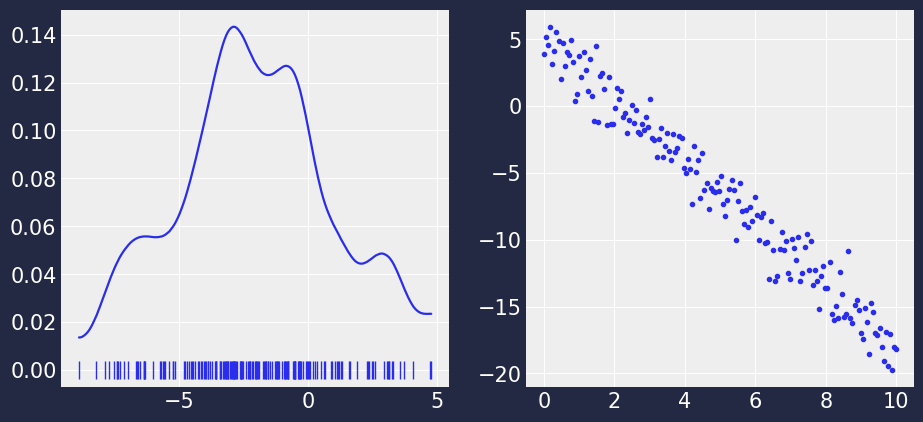

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(11,5))
textsize = plt.rcParams["axes.labelsize"]
az.plot_dist(data_normal, rug=True, ax=axes[0], rug_kwargs={"space": 0}, textsize=textsize);
axes[1].plot(data_x_regression, data_y_regression, ".");
axes[1].tick_params(labelsize=textsize)

### Estimating the parameters of a Gaussian random variable

In [6]:
with pm.Model() as model:
    # Define priors
    mu = pm.Normal("mu", mu=0, sd=10)
    sd = pm.HalfNormal("sd", sd=10)
    
    # Define likelihood
    likelihood = pm.Normal("obs", mu=mu, 
                        sd=sd, observed=data_normal)
    
    # Inference!
    trace = pm.sample() # draw posterior samples using NUTS sampling
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)

idata_normal = az.from_pymc3(
    trace=trace,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords=coords_normal,
    dims=dims_normal,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]
100%|██████████| 2000/2000 [00:01<00:00, 1442.59it/s]


/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


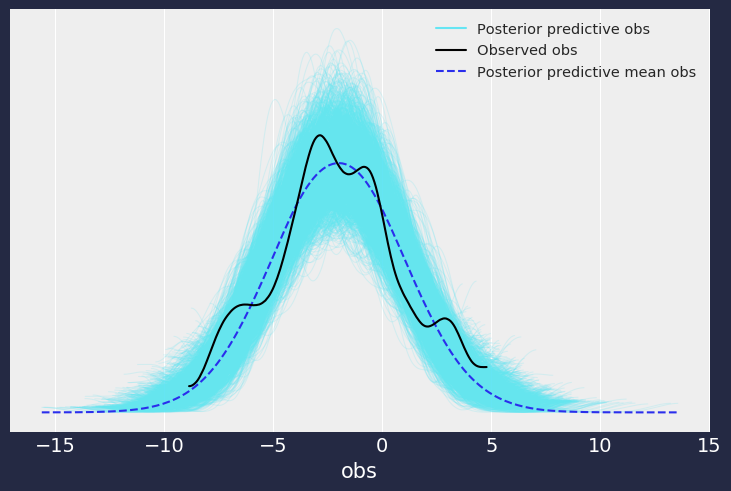

In [7]:
az.plot_ppc(idata_normal);

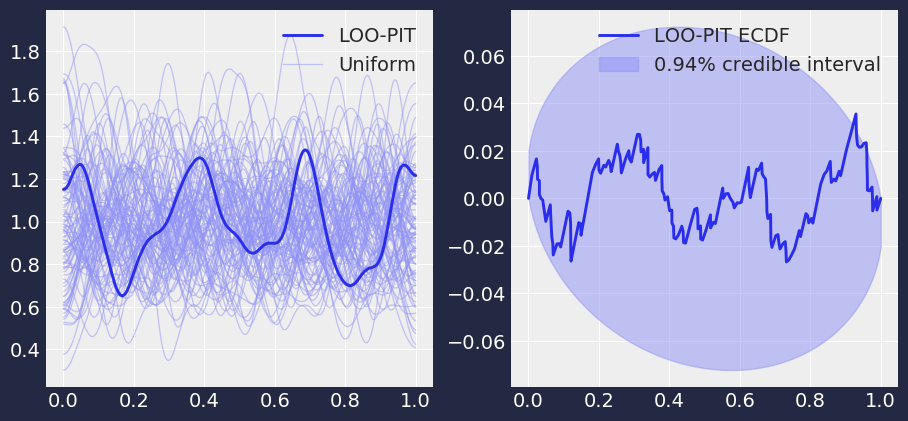

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(11,5))
for ax, ecdf in zip(axes, (False, True)):
    az.plot_loo_pit(idata_normal, y="obs", ecdf=ecdf, ax=ax);

In this first example, checking that the observed KDE is similar to the overlayed posterior predictive KDEs, is very similar and yield similar information to checking that the LOO-PIT KDE is similar to the overlayed uniform KDEs. In addition, similar informaion can be obteined from their interpretation.

For instance, one possibility is that these were mesures from some instrument, and it is common in this cases that the instrument reports an error which is used as standard deviation of the normal in the model. Below there are two examples, where in order to show the potential of the LOO-PIT predictive checks, the standard deviation of the data is fixed. First to a value a little larger than the real one, and then to a value a little smaller than the real one. 

These two examples show how the LOO-PIT looks like for overdispersed models (i.e. the error is assumed to be larger than what it actually is) and for underdispersed models (i.e. the error is assumed to be smaller than what it really is).

In [9]:
with pm.Model() as model:
    # Define priors
    mu = pm.Normal("mu", mu=0, sd=10)
    
    # Define likelihood
    likelihood = pm.Normal(
        "obs", mu=mu, sd=1.5 * sd_normal, observed=data_normal
    )
    
    # Inference!
    trace = pm.sample() # draw posterior samples using NUTS sampling
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
idata_normal_overdispersed = az.from_pymc3(
    trace=trace,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords=coords_normal,
    dims=dims_normal,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
100%|██████████| 2000/2000 [00:00<00:00, 2913.31it/s]


/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


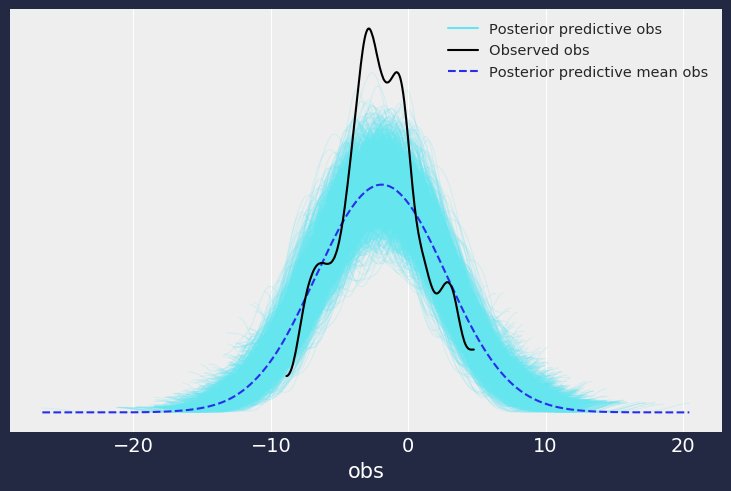

In [10]:
az.plot_ppc(idata_normal_overdispersed);

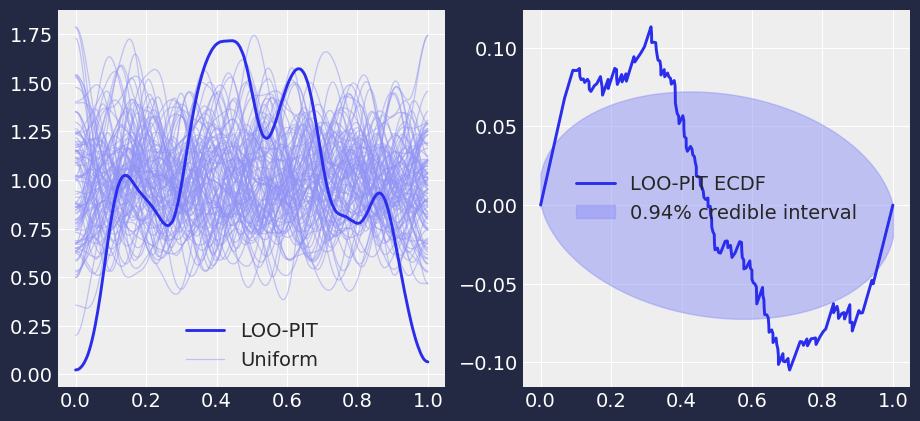

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(11,5))
for ax, ecdf in zip(axes, (False, True)):
    az.plot_loo_pit(idata_normal_overdispersed, y="obs", ecdf=ecdf, ax=ax);

In this example of overdispersed model, we can see that the posteriror predictive checks show that the observed KDE is narrower than most of the posterior predictive KDEs and narrower than the mean KDE of the posterior predictive samples, However, there are still some posterior predictive samples whose KDEs are similar to the observed KDE. In the LOO-PIT check though, there is no room for confursion. There is no overlayed distribution as extreme as the LOO-PIT KDE, and the difference between the Empirical Cumulative Density Function (ECDF) and the ideal uniform CDF lays outside the envelope most of the time.

In [12]:
with pm.Model() as model:
    # Define priors
    mu = pm.Normal("mu", mu=0, sd=10)
    
    # Define likelihood
    likelihood = pm.Normal(
        "obs", mu=mu, sd=.75 * sd_normal, observed=data_normal
    )
    
    # Inference!
    trace = pm.sample() # draw posterior samples using NUTS sampling
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
idata_normal_underdispersed = az.from_pymc3(
    trace=trace,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords=coords_normal,
    dims=dims_normal,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
100%|██████████| 2000/2000 [00:00<00:00, 3053.59it/s]


/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


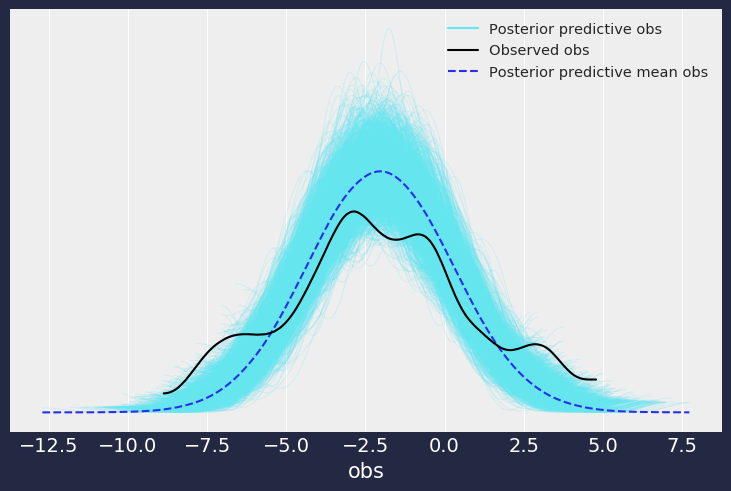

In [13]:
az.plot_ppc(idata_normal_underdispersed);

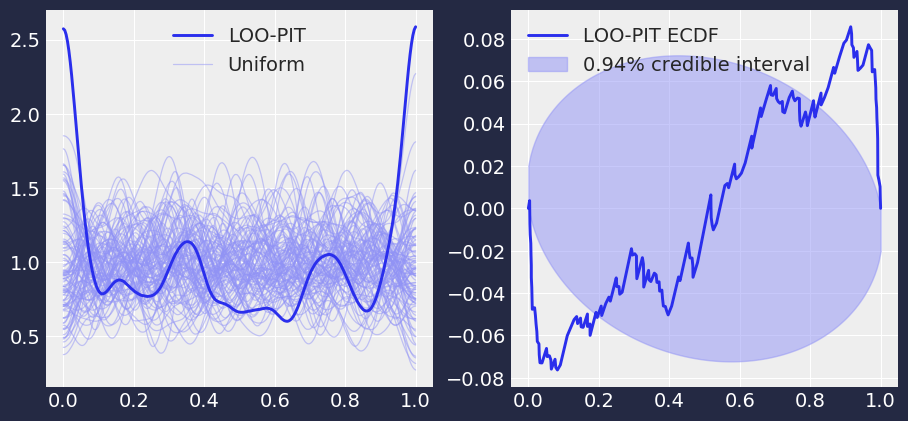

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(11,5))
for ax, ecdf in zip(axes, (False, True)):
    az.plot_loo_pit(idata_normal_underdispersed, y="obs", ecdf=ecdf, ax=ax);

Here, the differences are similar to the overdispersed case, modifying overdispersed by underdispersed. It is important to note though, that the LOO-PIT itself already indicates the problem with the model: a convex shape is a sign of an underdispersed model, and a concave shape is a sign of underdispersion.

In addition, LOO-PIT checks also show signs of model bias, as shown in the following example:

In [15]:
with pm.Model() as model:
    # Define priors
    sd = pm.HalfNormal("sd", sd=10)
    
    # Define likelihood
    likelihood = pm.Normal(
        "obs", mu=mu_normal - sd_normal / 2, sd=sd, observed=data_normal
    )
    
    # Inference!
    trace = pm.sample() # draw posterior samples using NUTS sampling
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
idata_normal_bias = az.from_pymc3(
    trace=trace,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords=coords_normal,
    dims=dims_normal,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd]
100%|██████████| 2000/2000 [00:01<00:00, 1429.65it/s]


/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


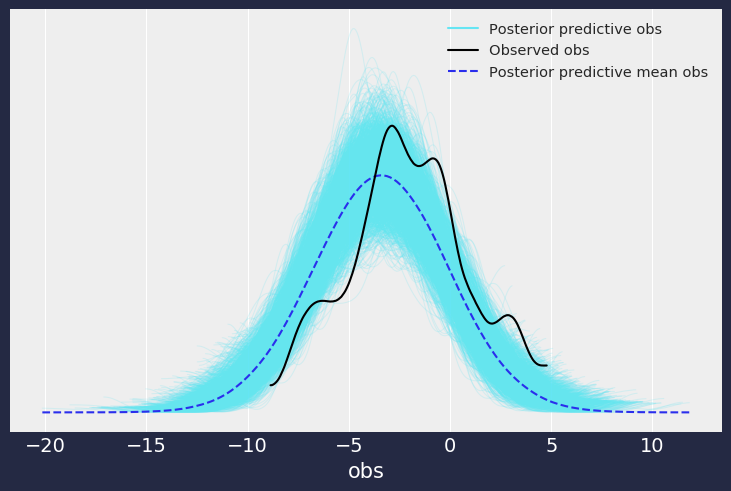

In [16]:
az.plot_ppc(idata_normal_bias);

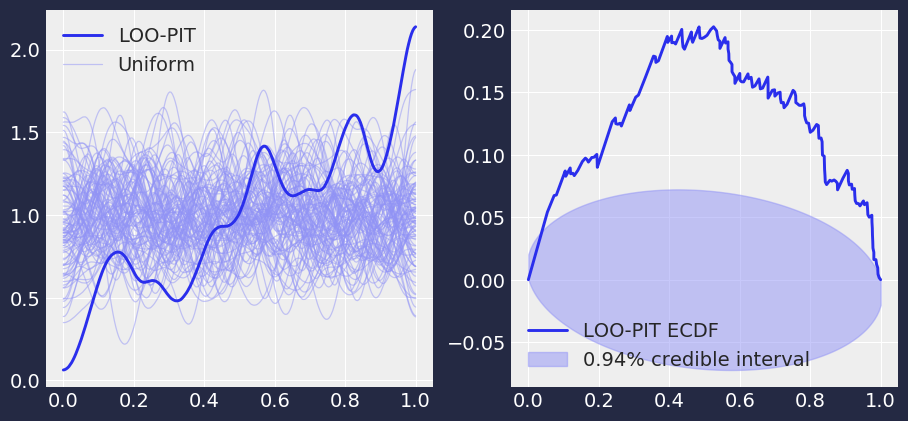

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(11,5))
for ax, ecdf in zip(axes, (False, True)):
    az.plot_loo_pit(idata_normal_bias, y="obs", ecdf=ecdf, ax=ax);

### Linear regression
In the case of a linear regression, the posterior predictive checks direclty do not give us much information, because each datapoint is centered at a different location, so combining them to create a single KDE won't yield useful results. This could be solved by rescaling each observation by substracting the mean along every observation from the posterior predictive though. 

In [18]:
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfNormal('sigma', sd=10)
    a0 = pm.Normal("a0", mu=0, sd=20)
    a1 = pm.Normal("a1", mu=0, sd=20)
    
    # Define likelihood
    likelihood = pm.Normal('y', mu=a0 + a1 * data_x_regression, 
                        sd=sigma, observed=data_y_regression)
    
    # Inference!
    trace = pm.sample() # draw posterior samples using NUTS sampling
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
idata_lr = az.from_pymc3(
    trace=trace,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords=coords_regression,
    dims=dims_regression,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a0, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2353.71draws/s]
The acceptance probability does not match the target. It is 0.8878515682888283, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 2000/2000 [00:01<00:00, 1075.35it/s]


/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


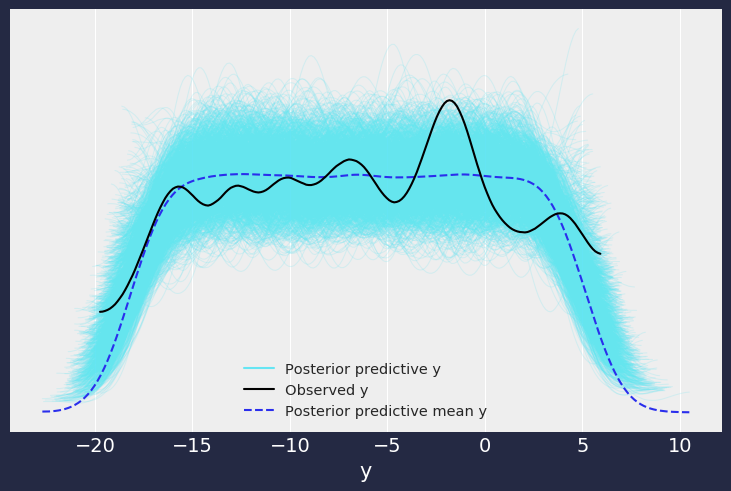

In [19]:
ax, = az.plot_ppc(idata_lr);

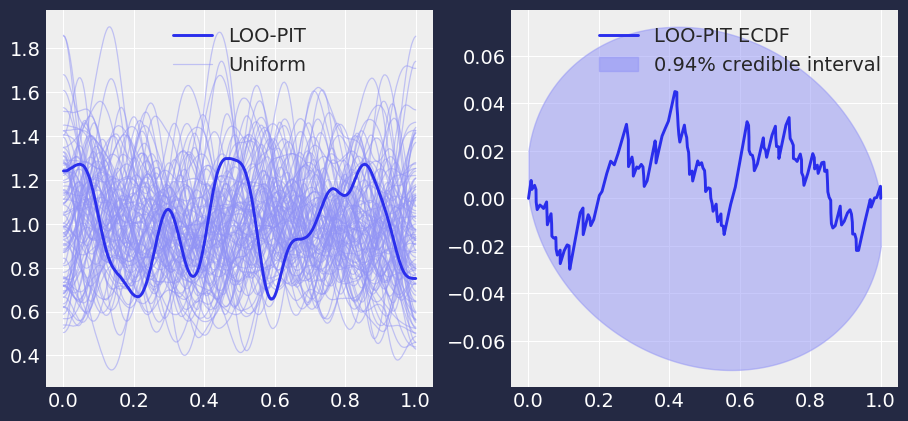

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(11,5))
for ax, ecdf in zip(axes, (False, True)):
    az.plot_loo_pit(idata_lr, y="y", ecdf=ecdf, ax=ax);

Now let's see how does introducing some small bias modifies the results.

In [21]:
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfNormal('sigma', sd=10)
    a1 = pm.Normal("a1", mu=0, sd=20)
    
    # Define likelihood
    likelihood = pm.Normal('y', mu=a0_lr + 2 + a1 * data_x_regression, 
                        sd=sigma, observed=data_y_regression)
    
    # Inference!
    trace = pm.sample() # draw posterior samples using NUTS sampling
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
idata_lr_bias = az.from_pymc3(
    trace=trace,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords=coords_regression,
    dims=dims_regression,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, sigma]
100%|██████████| 2000/2000 [00:01<00:00, 1125.39it/s]


/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


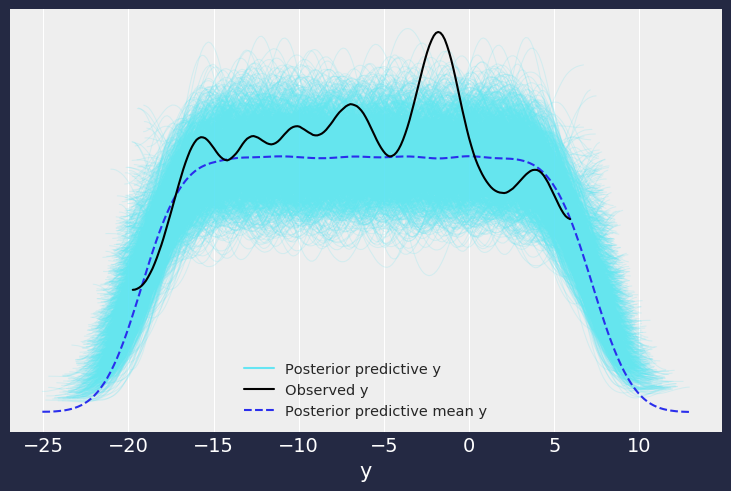

In [22]:
ax, = az.plot_ppc(idata_lr_bias);

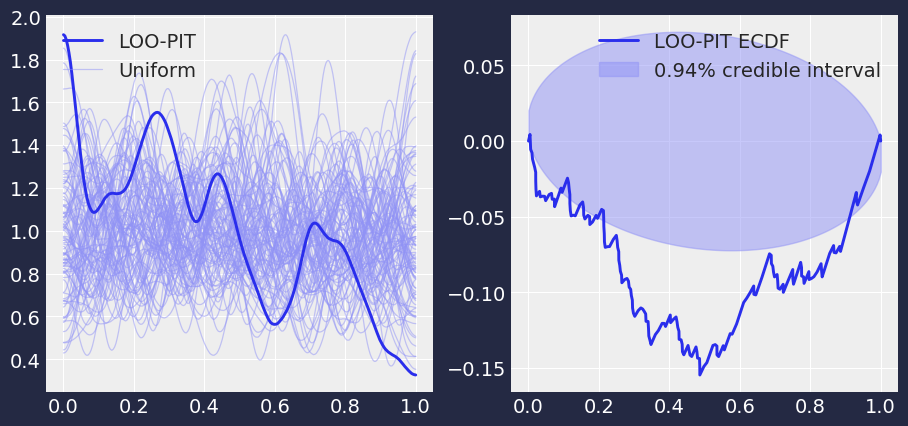

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(11,5))
for ax, ecdf in zip(axes, (False, True)):
    az.plot_loo_pit(idata_lr_bias, y="y", ecdf=ecdf, ax=ax);

Now the LOO-PIT check is clearly showing signs of bias in the model, whereas due to the lack of rescaling, no bias is seen in the posterior predictive checks.

Finally, let's combine some bias with overdispersion, to see how is LOO-PIT modified:

In [24]:
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    a1 = pm.Normal("a1", mu=0, sd=20)
    
    # Define likelihood
    likelihood = pm.Normal('y', mu=a0_lr + 2 + a1 * data_x_regression, 
                        sd=1.5 * sd_lr, observed=data_y_regression)
    
    # Inference!
    trace = pm.sample() # draw posterior samples using NUTS sampling
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
idata_lr_bias_overdispersed = az.from_pymc3(
    trace=trace,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords=coords_regression,
    dims=dims_regression,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1]
100%|██████████| 2000/2000 [00:01<00:00, 1757.98it/s]


/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


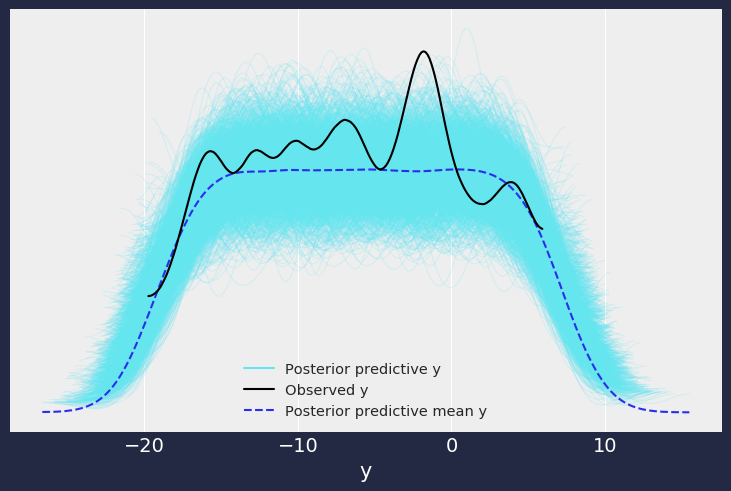

In [25]:
ax, = az.plot_ppc(idata_lr_bias_overdispersed);

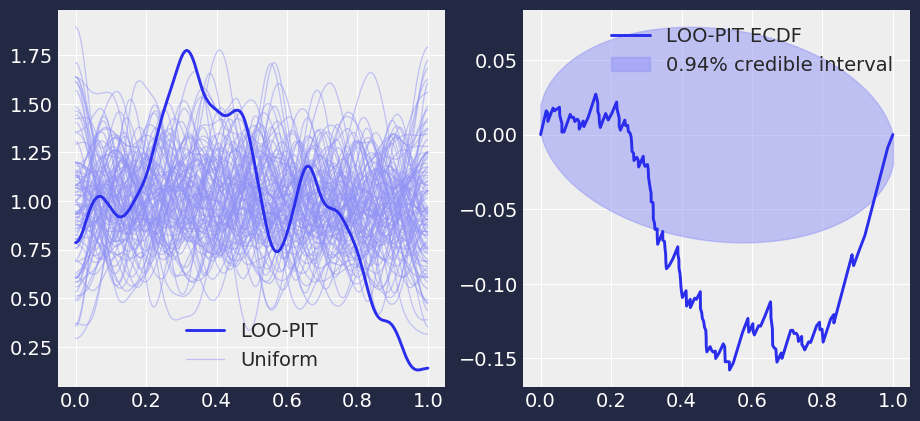

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(11,5))
for ax, ecdf in zip(axes, (False, True)):
    az.plot_loo_pit(idata_lr_bias_overdispersed, y="y", ecdf=ecdf, ax=ax);